In [389]:
#Importing Libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import warnings
from sklearn.linear_model import LinearRegression

#Extra settings
pd.set_option('display.max_columns',None) # Will not truncate the display of columns 
pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_rows',None) 
# np.set_printoptions(linewidth=10) 

In [321]:
#Loading train and test data
try:
    train_df=pd.read_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Dataset/train.csv')
    test_df=pd.read_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Dataset/test.csv')
    print("Train df shape: " ,train_df.shape)
    print("Test df shape: ", test_df.shape)

except FileNotFoundError:
    print("File not found")

Train df shape:  (1460, 81)
Test df shape:  (1459, 80)


In [322]:
#Getting summary of all columns
train_df_description=train_df.describe(include='all')
print(train_df_description)

                 Id   MSSubClass MSZoning  LotFrontage        LotArea Street  \
count   1460.000000  1460.000000     1460  1201.000000    1460.000000   1460   
unique          NaN          NaN        5          NaN            NaN      2   
top             NaN          NaN       RL          NaN            NaN   Pave   
freq            NaN          NaN     1151          NaN            NaN   1454   
mean     730.500000    56.897260      NaN    70.049958   10516.828082    NaN   
std      421.610009    42.300571      NaN    24.284752    9981.264932    NaN   
min        1.000000    20.000000      NaN    21.000000    1300.000000    NaN   
25%      365.750000    20.000000      NaN    59.000000    7553.500000    NaN   
50%      730.500000    50.000000      NaN    69.000000    9478.500000    NaN   
75%     1095.250000    70.000000      NaN    80.000000   11601.500000    NaN   
max     1460.000000   190.000000      NaN   313.000000  215245.000000    NaN   

       Alley LotShape LandContour Utili

In [323]:
categorical_cols = [col for col in train_df.columns if train_df[col].dtype == 'object'] #selecing only categorical columns

numeric_cols_df=train_df.select_dtypes(include=['number']) # selecting only numeric columns for correlation matrix and creating and df.
print(len(categorical_cols))
print(numeric_cols_df.shape)

print(len(categorical_cols)+numeric_cols_df.shape[1]==train_df.shape[1]) #checking if no. categorical cols+ cols in numeric_cols_df matches the original train df

43
(1460, 38)
True


Text(0.5, 1.0, 'Correlation Heatmap')

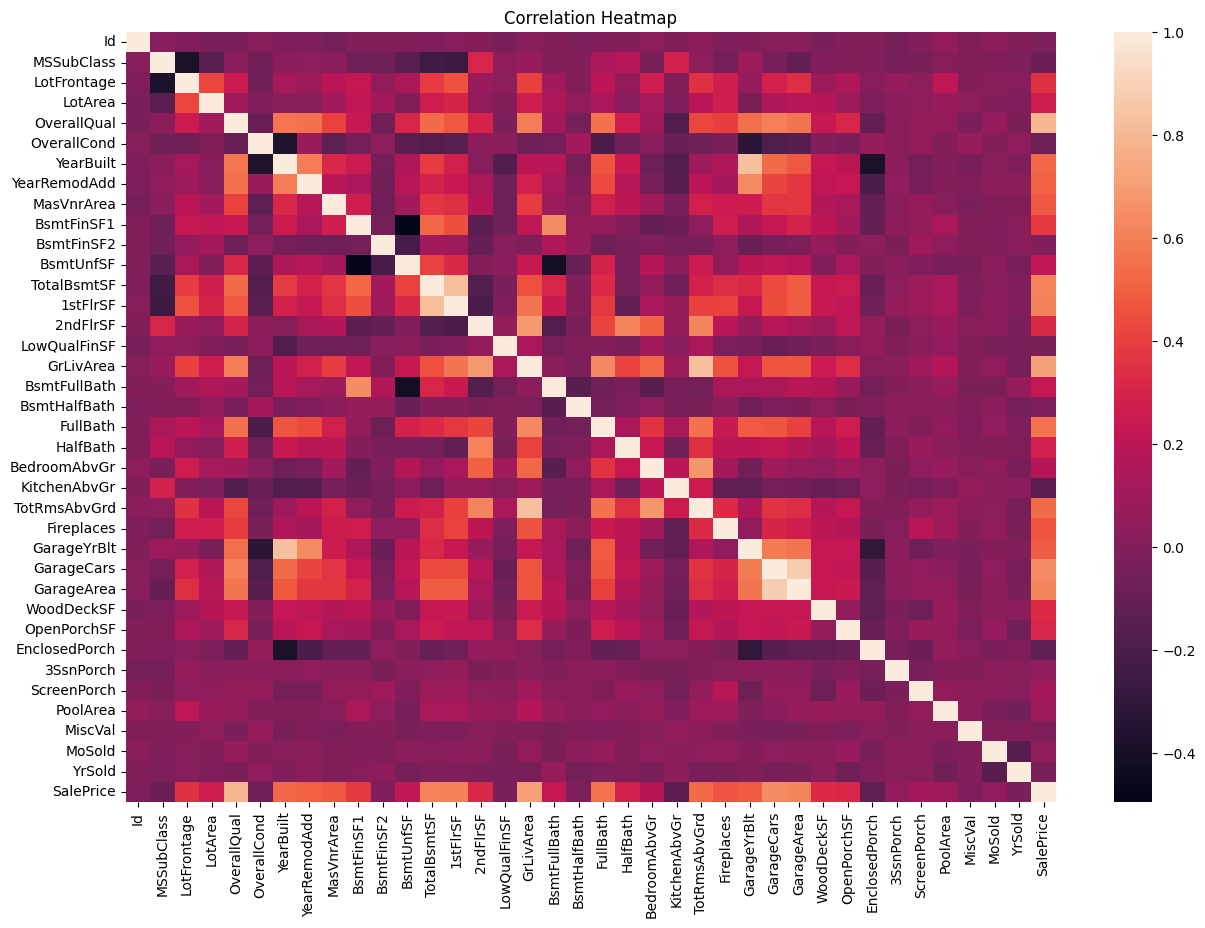

In [324]:
#Creating correlation matrix
correlation_matrix=numeric_cols_df.corr()

#Creating heatmap from the matrix
plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix,fmt='.2f',annot_kws={"size":6})
plt.title('Correlation Heatmap')

In [325]:
# Find  absolute correlations>0.8 (excluding self-correlations)
top_correlations = correlation_matrix.unstack().abs().sort_values(ascending=False)
top_correlations = top_correlations[(top_correlations >= 0.8) & (top_correlations!=1)]
print(top_correlations)

print('\nWe will analyse these columns with high correlation.')

GarageArea    GarageCars      0.882475
GarageCars    GarageArea      0.882475
GarageYrBlt   YearBuilt       0.825667
YearBuilt     GarageYrBlt     0.825667
GrLivArea     TotRmsAbvGrd    0.825489
TotRmsAbvGrd  GrLivArea       0.825489
TotalBsmtSF   1stFlrSF        0.819530
1stFlrSF      TotalBsmtSF     0.819530
dtype: float64

We will analyse these columns with high correlation.


In [326]:
top_correlations_cols=top_correlations.index.get_level_values(0)
print(top_correlations_cols)

Index(['GarageArea', 'GarageCars', 'GarageYrBlt', 'YearBuilt', 'GrLivArea',
       'TotRmsAbvGrd', 'TotalBsmtSF', '1stFlrSF'],
      dtype='object')


In [327]:
mask_null_corr=numeric_cols_df[top_correlations_cols].isnull()
mask_blank_corr=numeric_cols_df[top_correlations_cols].eq('')
mask_zero_corr=numeric_cols_df[top_correlations_cols].eq(0)

null_count_high_corr_df=mask_null_corr.sum()
blank_count_high_corr_df=mask_blank_corr.sum()
zero_count_high_corr_df=mask_zero_corr.sum()

print("\nNull count in the columns with high correlation:\n")
print(null_count_high_corr_df)

print("\nBlank count in the columns with high correlation:\n")
print(blank_count_high_corr_df)

print("\nZero count in the columns with high correlation:\n")
print(zero_count_high_corr_df)

print('\nNotes:')
print('GarageYrBlt and YearBuilt has 0.825667 correlation. Most probably signifies\n\
whenever the house was constructed at the same time garage was also constructed.\n\
As GarageYrBlt  has 81 nulls compared to Yearbuilt(0 nulls) we\n\
can delete GarageYrBlt\n')



Null count in the columns with high correlation:

GarageArea       0
GarageCars       0
GarageYrBlt     81
YearBuilt        0
GrLivArea        0
TotRmsAbvGrd     0
TotalBsmtSF      0
1stFlrSF         0
dtype: int64

Blank count in the columns with high correlation:

GarageArea      0
GarageCars      0
GarageYrBlt     0
YearBuilt       0
GrLivArea       0
TotRmsAbvGrd    0
TotalBsmtSF     0
1stFlrSF        0
dtype: int64

Zero count in the columns with high correlation:

GarageArea      81
GarageCars      81
GarageYrBlt      0
YearBuilt        0
GrLivArea        0
TotRmsAbvGrd     0
TotalBsmtSF     37
1stFlrSF         0
dtype: int64

Notes:
GarageYrBlt and YearBuilt has 0.825667 correlation. Most probably signifies
whenever the house was constructed at the same time garage was also constructed.
As GarageYrBlt  has 81 nulls compared to Yearbuilt(0 nulls) we
can delete GarageYrBlt



In [328]:

Garage_Check_train=train_df[train_df['GarageYrBlt'].isnull()]
Garage_Check_train=Garage_Check_train[['Id','GarageYrBlt','GarageCond','GarageQual','GarageCars','GarageArea','GarageFinish','GarageType','SalePrice']]
Garage_Check_train_summary=Garage_Check_train.describe(include='all')
Garage_Check_train_summary=Garage_Check_train_summary.T
display(Garage_Check_train_summary)

Garage_Not_Null_Check_train=train_df[train_df['GarageYrBlt'].notnull()]
Garage_Not_Null_Check_train=Garage_Not_Null_Check_train[['Id','GarageYrBlt','GarageCond','GarageQual','GarageCars','GarageArea','GarageFinish','GarageType','SalePrice']]
Garage_Not_Null_Check_train_summary=Garage_Not_Null_Check_train.describe(include='all')
Garage_Not_Null_Check_train_summary=Garage_Not_Null_Check_train_summary.T
display(Garage_Not_Null_Check_train_summary)

print('It looks like wherever GarageYrBlt is null the other garage variables are also null or 0.\nMost probably no garage was built was these records.\nWe will check correlation b/w :\n\n\
1)GarageArea vs SalePrice\n2)GarageCars vs SalePrice.\n3)Whichever is showing lower relation  among these 2 will be deleted \
      ')

print('\nChecking correlations\n')
garage_area_vs_saleprice = correlation_matrix.loc['GarageArea', 'SalePrice']
print("The correlation between Garage Area and Sale Price is:", garage_area_vs_saleprice)

garage_cars_vs_saleprice = correlation_matrix.loc['GarageCars', 'SalePrice']
print("The correlation between Garage Cars and Sale Price is:", garage_cars_vs_saleprice) 
print(f'\nWe can delete GarageArea as the correlation.')

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,81.0,NaN,NaN,NaN,707.012346,432.877104,40.0,308.0,639.0,1097.0,1454.0
GarageYrBlt,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GarageCond,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GarageQual,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GarageCars,81.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GarageArea,81.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GarageFinish,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GarageType,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SalePrice,81.0,NaN,NaN,NaN,103317.283951,32815.023389,34900.0,82500.0,100000.0,124000.0,200500.0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,1379.0,NaN,NaN,NaN,731.879623,421.059059,1.0,366.5,734.0,1094.5,1460.0
GarageYrBlt,1379.0,NaN,NaN,NaN,1978.506164,24.689725,1900.0,1961.0,1980.0,2002.0,2010.0
GarageCond,1379,5,TA,1326,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GarageQual,1379,5,TA,1311,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GarageCars,1379.0,NaN,NaN,NaN,1.870921,0.630055,1.0,1.0,2.0,2.0,4.0
GarageArea,1379.0,NaN,NaN,NaN,500.762146,185.68052,160.0,380.0,484.0,580.0,1418.0
GarageFinish,1379,3,Unf,605,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GarageType,1379,6,Attchd,870,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SalePrice,1379.0,NaN,NaN,NaN,185479.51124,79023.8906,35311.0,134000.0,167500.0,217750.0,755000.0


It looks like wherever GarageYrBlt is null the other garage variables are also null or 0.
Most probably no garage was built was these records.
We will check correlation b/w :

1)GarageArea vs SalePrice
2)GarageCars vs SalePrice.
3)Whichever is showing lower relation  among these 2 will be deleted       

Checking correlations

The correlation between Garage Area and Sale Price is: 0.6234314389183622
The correlation between Garage Cars and Sale Price is: 0.6404091972583519

We can delete GarageArea as the correlation.


In [329]:
TotRmsAbvGrd_vs_saleprice = correlation_matrix.loc['TotRmsAbvGrd', 'SalePrice']
GrLivArea_vs_saleprice = correlation_matrix.loc['GrLivArea', 'SalePrice']
print("The correlation between TotRmsAbvGrd and Sale Price, GrLivArea and Sale Price :", TotRmsAbvGrd_vs_saleprice,GrLivArea_vs_saleprice)

FirstFlrSF_vs_saleprice= correlation_matrix.loc['1stFlrSF', 'SalePrice']
TotalBsmtSF_vs_saleprice=correlation_matrix.loc['TotalBsmtSF','SalePrice']
print("The correlation between 1stFlrSF and Sale Price, TotalBsmtSF and Sale Price :", FirstFlrSF_vs_saleprice,TotalBsmtSF_vs_saleprice)

print('\nGrLivArea Looks like better predictor for saleprice as compared to TotRmsAbvGrd.\nHigher living area leads to higher saleprice\n\
We can delete TotRmsAbvGrd.')

print('\nWe can\'t choose which one to delete among 1stFlrSF and TotalBsmtSF yet. As we saw earlier TotalBsmtSF has 37 0\'s. Let\'s analyse this more.')


The correlation between TotRmsAbvGrd and Sale Price, GrLivArea and Sale Price : 0.5337231555820284 0.7086244776126515
The correlation between 1stFlrSF and Sale Price, TotalBsmtSF and Sale Price : 0.6058521846919153 0.6135805515591943

GrLivArea Looks like better predictor for saleprice as compared to TotRmsAbvGrd.
Higher living area leads to higher saleprice
We can delete TotRmsAbvGrd.

We can't choose which one to delete among 1stFlrSF and TotalBsmtSF yet. As we saw earlier TotalBsmtSF has 37 0's. Let's analyse this more.


In [330]:
TotalBsmtSF_zero_df=train_df[train_df['TotalBsmtSF']==0]
TotalBsmtSF_zero_df.shape
TotalBsmtSF_zero_df=TotalBsmtSF_zero_df[['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','SalePrice']]
display(TotalBsmtSF_zero_df.describe(include='all').T)

print('We will try to combine columns 1stFlrSF and 2ndFlrSF to check if we can increase the prediction power.\nThese 37 rows for basement doesn\'t seem to have basement built.')

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
BsmtQual,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BsmtCond,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BsmtExposure,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BsmtFinType1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BsmtFinSF1,37.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BsmtFinType2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BsmtFinSF2,37.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BsmtUnfSF,37.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TotalBsmtSF,37.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SalePrice,37.0,NaN,NaN,NaN,105652.891892,29278.694797,39300.0,90000.0,101800.0,118858.0,198500.0


We will try to combine columns 1stFlrSF and 2ndFlrSF to check if we can increase the prediction power.
These 37 rows for basement doesn't seem to have basement built.


In [331]:
numeric_cols_df_Total_sq_feet = numeric_cols_df.copy()

numeric_cols_df_Total_sq_feet['totsqlft'] = numeric_cols_df_Total_sq_feet['1stFlrSF'] + numeric_cols_df_Total_sq_feet['2ndFlrSF']
correlation_matrix_TotSqFeet=numeric_cols_df_Total_sq_feet.corr()
print(correlation_matrix_TotSqFeet.loc['totsqlft','SalePrice'])
print(correlation_matrix_TotSqFeet.loc['1stFlrSF','SalePrice'])
print(correlation_matrix_TotSqFeet.loc['2ndFlrSF','SalePrice'])
print(correlation_matrix_TotSqFeet.loc['TotalBsmtSF','SalePrice'])
print(correlation_matrix_TotSqFeet.loc['TotalBsmtSF','totsqlft'])

print('\nWe combined 1stFlrSF and 2ndFlrSF which is giving more predictive power for\nsaleprice meanwhile reducing the multicollinearity.\
This will be a new column and\n1stFlrSF & 2ndFlrSF will be deleted.')

0.71688307936928
0.6058521846919153
0.31933380283206736
0.6135805515591943
0.46173763145297125

We combined 1stFlrSF and 2ndFlrSF which is giving more predictive power for
saleprice meanwhile reducing the multicollinearity.This will be a new column and
1stFlrSF & 2ndFlrSF will be deleted.


In [332]:
top_correlations_tot_sq_feet = correlation_matrix_TotSqFeet.unstack().abs().sort_values(ascending=False)
top_correlations_tot_sq_feet_check = top_correlations_tot_sq_feet[(top_correlations_tot_sq_feet >= 0.7) & (top_correlations_tot_sq_feet!=1)]
print(top_correlations_tot_sq_feet_check)

print(top_correlations_tot_sq_feet_check.loc['totsqlft','SalePrice'])
print(top_correlations_tot_sq_feet_check.loc['GrLivArea','SalePrice'])
print('\nWe can now drop GrLivArea too as they have multicollineairty of 0.99 while the totsqlft has higher predicitve power for saleprice.')

GrLivArea     totsqlft        0.995718
totsqlft      GrLivArea       0.995718
GarageArea    GarageCars      0.882475
GarageCars    GarageArea      0.882475
GarageYrBlt   YearBuilt       0.825667
YearBuilt     GarageYrBlt     0.825667
GrLivArea     TotRmsAbvGrd    0.825489
TotRmsAbvGrd  GrLivArea       0.825489
              totsqlft        0.820088
totsqlft      TotRmsAbvGrd    0.820088
TotalBsmtSF   1stFlrSF        0.819530
1stFlrSF      TotalBsmtSF     0.819530
OverallQual   SalePrice       0.790982
SalePrice     OverallQual     0.790982
totsqlft      SalePrice       0.716883
SalePrice     totsqlft        0.716883
GrLivArea     SalePrice       0.708624
SalePrice     GrLivArea       0.708624
dtype: float64
0.71688307936928
0.7086244776126515

We can now drop GrLivArea too as they have multicollineairty of 0.99 while the totsqlft has higher predicitve power for saleprice.


In [333]:
print('Let\'s see if we can increase predictive power for Bsmt variables or not.\n')
bsmt_cols = [cols for cols in numeric_cols_df.columns if 'bsmt' in cols.lower()]

multicollinearity_output = ''  
for i in bsmt_cols:
    for j in bsmt_cols:
        if correlation_matrix_TotSqFeet.loc[i, j] != 1:
            multicollinearity_output += f'multicollinearity for columns {i} and {j} {correlation_matrix_TotSqFeet.loc[i, j]}\n'
    multicollinearity_output += f'multicollinearity for columns {i} and SalePrice {correlation_matrix_TotSqFeet.loc[i, "SalePrice"]}\n\n'

# Now, let's process the output and create a DataFrame
data = []
for line in multicollinearity_output.strip().split('\n'):
    match = re.match(r"multicollinearity for columns (\w+) and (\w+) ([-\d.]+)", line)
    if match:
        col1, col2, value = match.groups()
        data.append([col1, col2, float(value)])

df_bsmt_correlation = pd.DataFrame(data, columns=['Column1', 'Column2', 'Correlation'])
df_bsmt_correlation_sorted=df_bsmt_correlation.sort_values(by='Correlation',ascending=False)

display(df_bsmt_correlation_sorted[df_bsmt_correlation_sorted['Column2']=='SalePrice'])

print('correlations>=0.3\n')
display(df_bsmt_correlation_sorted[df_bsmt_correlation_sorted['Correlation']>=0.3])

print('correlations<=-0.3\n')
display(df_bsmt_correlation_sorted[df_bsmt_correlation_sorted['Correlation']<=-0.3])


Let's see if we can increase predictive power for Bsmt variables or not.



,Column1,Column2,Correlation
23,TotalBsmtSF,SalePrice,0.613581
5,BsmtFinSF1,SalePrice,0.386420
29,BsmtFullBath,SalePrice,0.227122
17,BsmtUnfSF,SalePrice,0.214479
11,BsmtFinSF2,SalePrice,-0.011378
35,BsmtHalfBath,SalePrice,-0.016844


correlations>=0.3



,Column1,Column2,Correlation
3,BsmtFinSF1,BsmtFullBath,0.649212
24,BsmtFullBath,BsmtFinSF1,0.649212
23,TotalBsmtSF,SalePrice,0.613581
18,TotalBsmtSF,BsmtFinSF1,0.522396
2,BsmtFinSF1,TotalBsmtSF,0.522396
14,BsmtUnfSF,TotalBsmtSF,0.415360
20,TotalBsmtSF,BsmtUnfSF,0.415360
5,BsmtFinSF1,SalePrice,0.386420
21,TotalBsmtSF,BsmtFullBath,0.307351
27,BsmtFullBath,TotalBsmtSF,0.307351


correlations<=-0.3



,Column1,Column2,Correlation
26,BsmtFullBath,BsmtUnfSF,-0.422900
15,BsmtUnfSF,BsmtFullBath,-0.422900
1,BsmtFinSF1,BsmtUnfSF,-0.495251
12,BsmtUnfSF,BsmtFinSF1,-0.495251


In [334]:
#Feature engineering bsmt cols
numeric_cols_df_bsmt_feat_eng = numeric_cols_df_Total_sq_feet.copy()

New_bsmt_cols=[]
for i in range(len(bsmt_cols) - 1):
    for j in range(i + 1, len(bsmt_cols)):
        New_bsmt_cols.append('+'.join(bsmt_cols[i:j + 1]))

for i in New_bsmt_cols:
    split_cols=i.split('+')
    split_cols_len=len(split_cols)
    numeric_cols_df_bsmt_feat_eng[i]=0
    for j in split_cols:
        numeric_cols_df_bsmt_feat_eng[i]+=numeric_cols_df_bsmt_feat_eng[j]
        
#Creating correlation matrix from numeric_cols_df_bsmt_feat_eng
correlation_matrix_numeric_cols_df_bsmt_feat_eng=numeric_cols_df_bsmt_feat_eng.corr()

multicollinearity_output_bsmt = ''  
for i in New_bsmt_cols:
    for j in New_bsmt_cols:
        if correlation_matrix_numeric_cols_df_bsmt_feat_eng.loc[i, j] != 1:
            multicollinearity_output_bsmt += f'multicollinearity for columns {i} and {j} {correlation_matrix_numeric_cols_df_bsmt_feat_eng.loc[i, j]}\n'
    multicollinearity_output_bsmt += f'multicollinearity for columns {i} and SalePrice {correlation_matrix_numeric_cols_df_bsmt_feat_eng.loc[i, "SalePrice"]}\n\n'

# Now, let's process the output and create a DataFrame
data_bsmt = []
for line in multicollinearity_output_bsmt.strip().split('\n'):
    match = re.match(r"multicollinearity for columns (.+) and (.+) ([-\d\.]+)", line)
    if match:
        col1, col2, value = match.groups()

        data_bsmt.append([col1, col2, float(value)])

df_bsmt_feat_correlation = pd.DataFrame(data_bsmt, columns=['Column1', 'Column2', 'Correlation'])
df_bsmt_feat_correlation_sorted=df_bsmt_feat_correlation.sort_values(by='Correlation',ascending=False)

display(df_bsmt_correlation_sorted[df_bsmt_correlation_sorted['Column2']=='SalePrice'])

display(df_bsmt_feat_correlation_sorted[df_bsmt_feat_correlation_sorted['Column2']=='SalePrice'])


print('\nBsmtFinSF1+BsmtFinSF2+BsmtUnfSF and TotalBsmtSF has same correlation against SalePrice.\n\
Upon checking the data they both have same data.\n\
We can use TotalBsmtSF+BsmtFullBath+BsmtHalfBath as it has the second highest correlation against salesprice.\n\
This is slighlty better than the\n\
collinearity between TotalBsmtSF vs Saleprice\n\
Why not the first one?\n\
Because the first one doesn\'nt account for Halfbath and in the first table we\n\
saw halfbath has a slight negative relation against saleprice We can delete the other columns. ALso we will create a box plot for baths.\n')



,Column1,Column2,Correlation
23,TotalBsmtSF,SalePrice,0.613581
5,BsmtFinSF1,SalePrice,0.386420
29,BsmtFullBath,SalePrice,0.227122
17,BsmtUnfSF,SalePrice,0.214479
11,BsmtFinSF2,SalePrice,-0.011378
35,BsmtHalfBath,SalePrice,-0.016844


,Column1,Column2,Correlation
192,TotalBsmtSF+BsmtFullBath,SalePrice,0.613626
207,TotalBsmtSF+BsmtFullBath+BsmtHalfBath,SalePrice,0.613617
57,BsmtFinSF1+BsmtFinSF2+BsmtUnfSF+TotalBsmtSF+BsmtFullBath,SalePrice,0.613603
72,BsmtFinSF1+BsmtFinSF2+BsmtUnfSF+TotalBsmtSF+BsmtFullBath+BsmtHalfBath,SalePrice,0.613599
42,BsmtFinSF1+BsmtFinSF2+BsmtUnfSF+TotalBsmtSF,SalePrice,0.613581
28,BsmtFinSF1+BsmtFinSF2+BsmtUnfSF,SalePrice,0.613581
177,BsmtUnfSF+TotalBsmtSF+BsmtFullBath+BsmtHalfBath,SalePrice,0.491502
162,BsmtUnfSF+TotalBsmtSF+BsmtFullBath,SalePrice,0.491498
147,BsmtUnfSF+TotalBsmtSF,SalePrice,0.491315
132,BsmtFinSF2+BsmtUnfSF+TotalBsmtSF+BsmtFullBath+BsmtHalfBath,SalePrice,0.484171



BsmtFinSF1+BsmtFinSF2+BsmtUnfSF and TotalBsmtSF has same correlation against SalePrice.
Upon checking the data they both have same data.
We can use TotalBsmtSF+BsmtFullBath+BsmtHalfBath as it has the second highest correlation against salesprice.
This is slighlty better than the
collinearity between TotalBsmtSF vs Saleprice
Why not the first one?
Because the first one doesn'nt account for Halfbath and in the first table we
saw halfbath has a slight negative relation against saleprice We can delete the other columns. ALso we will create a box plot for baths.



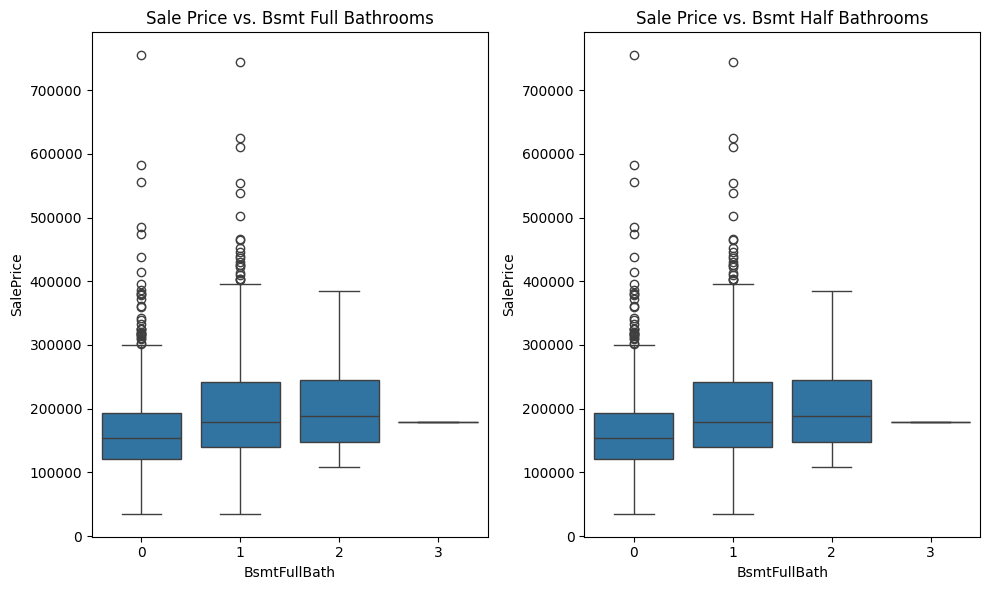

In [335]:
#Boxplot for saleprice vs bsmtfullbath/bsmthalfbath
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='BsmtFullBath', y='SalePrice', data=numeric_cols_df)
plt.title('Sale Price vs. Bsmt Full Bathrooms')

plt.subplot(1, 2, 2)
sns.boxplot(x='BsmtFullBath', y='SalePrice', data=numeric_cols_df)
plt.title('Sale Price vs. Bsmt Half Bathrooms')

plt.tight_layout()
plt.show()


In [336]:
#Moving on to wood deck and porsch variables
Wood_porsch_col=['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','SalePrice']
Wood_porsch_col_df=numeric_cols_df[Wood_porsch_col]
Wood_porsch_corr=Wood_porsch_col_df.corr()

for col in Wood_porsch_col:
     print(f'Correlation between {col} and SalePrice' ,Wood_porsch_corr.loc[col,'SalePrice'])

Correlation between WoodDeckSF and SalePrice 0.32441344456812926
Correlation between OpenPorchSF and SalePrice 0.31585622711605504
Correlation between EnclosedPorch and SalePrice -0.1285779579259566
Correlation between 3SsnPorch and SalePrice 0.04458366533574838
Correlation between ScreenPorch and SalePrice 0.11144657114291112
Correlation between SalePrice and SalePrice 1.0


In [337]:
#Feature engineering wood and porsch cols
numeric_cols_df_wood_porsch_feat_eng = numeric_cols_df_Total_sq_feet.copy()

New_wood_porsch_cols=[]
for i in range(len(Wood_porsch_col) - 1):
     for j in range(i + 1, len(Wood_porsch_col)):
         New_wood_porsch_cols.append('+'.join(Wood_porsch_col[i:j + 1]))

for i in New_wood_porsch_cols:
     split_cols=i.split('+')
     split_cols_len=len(split_cols)
     numeric_cols_df_wood_porsch_feat_eng[i]=0
     for j in split_cols:
         numeric_cols_df_wood_porsch_feat_eng[i]+=numeric_cols_df_wood_porsch_feat_eng[j]
        
#Creating correlation matrix from numeric_cols_df_bsmt_feat_eng
correlation_matrix_numeric_cols_df_wood_porsch_feat_eng=numeric_cols_df_wood_porsch_feat_eng.corr()

multicollinearity_output_porsch = ''  
for i in New_wood_porsch_cols:
     for j in New_wood_porsch_cols:
         if correlation_matrix_numeric_cols_df_wood_porsch_feat_eng.loc[i, j] != 1:
             multicollinearity_output_porsch += f'multicollinearity for columns {i} and {j} {correlation_matrix_numeric_cols_df_wood_porsch_feat_eng.loc[i, j]}\n'
     multicollinearity_output_porsch += f'multicollinearity for columns {i} and SalePrice {correlation_matrix_numeric_cols_df_wood_porsch_feat_eng.loc[i, "SalePrice"]}\n\n'

 # Now, let's process the output and create a DataFrame
data_wood_porsch = []
for line in multicollinearity_output_porsch.strip().split('\n'):
     match = re.match(r"multicollinearity for columns (.+) and (.+) ([-\d\.]+)", line)
     if match:
         col1, col2, value = match.groups()

         data_wood_porsch.append([col1, col2, float(value)])

df_wood_porsch_feat_correlation = pd.DataFrame(data_wood_porsch, columns=['Column1', 'Column2', 'Correlation'])
df_wood_porsch_feat_correlation_sorted=df_wood_porsch_feat_correlation.sort_values(by='Correlation',ascending=False)

for col in Wood_porsch_col:
     print(f'Correlation between {col} and SalePrice' ,Wood_porsch_corr.loc[col,'SalePrice'])

display(df_wood_porsch_feat_correlation_sorted[df_wood_porsch_feat_correlation_sorted['Column2']=='SalePrice'])


print('WoodDeckSF+OpenPorchSF+EnclosedPorch+3SsnPorch+ScreenPorch has 0.39 correlation. We can use this instead of other separate cols')



Correlation between WoodDeckSF and SalePrice 0.32441344456812926
Correlation between OpenPorchSF and SalePrice 0.31585622711605504
Correlation between EnclosedPorch and SalePrice -0.1285779579259566
Correlation between 3SsnPorch and SalePrice 0.04458366533574838
Correlation between ScreenPorch and SalePrice 0.11144657114291112
Correlation between SalePrice and SalePrice 1.0


,Column1,Column2,Correlation
224,ScreenPorch+SalePrice,SalePrice,1.000000
209,3SsnPorch+ScreenPorch+SalePrice,SalePrice,1.000000
179,EnclosedPorch+3SsnPorch+ScreenPorch+SalePrice,SalePrice,0.999999
134,OpenPorchSF+EnclosedPorch+3SsnPorch+ScreenPorch+SalePrice,SalePrice,0.999999
74,WoodDeckSF+OpenPorchSF+EnclosedPorch+3SsnPorch+ScreenPorch+SalePrice,SalePrice,0.999998
14,WoodDeckSF+OpenPorchSF,SalePrice,0.424258
59,WoodDeckSF+OpenPorchSF+EnclosedPorch+3SsnPorch+ScreenPorch,SalePrice,0.390993
44,WoodDeckSF+OpenPorchSF+EnclosedPorch+3SsnPorch,SalePrice,0.366204
29,WoodDeckSF+OpenPorchSF+EnclosedPorch,SalePrice,0.361223
119,OpenPorchSF+EnclosedPorch+3SsnPorch+ScreenPorch,SalePrice,0.195739


WoodDeckSF+OpenPorchSF+EnclosedPorch+3SsnPorch+ScreenPorch has 0.39 correlation. We can use this instead of other separate cols


In [338]:
#PoolARea, LotArea,totsqlft
Area_col=['PoolArea','LotArea','totsqlft','LotFrontage','SalePrice']
Area_col_df=numeric_cols_df_Total_sq_feet[Area_col]
Area_col_df_corr=Area_col_df.corr()

for col in Area_col:
     print(f'Correlation between {col} and SalePrice' ,Area_col_df_corr.loc[col,'SalePrice'])
print('\n')
Area_col_df_corr

Correlation between PoolArea and SalePrice 0.09240354949187318
Correlation between LotArea and SalePrice 0.2638433538714051
Correlation between totsqlft and SalePrice 0.71688307936928
Correlation between LotFrontage and SalePrice 0.35179909657067737
Correlation between SalePrice and SalePrice 1.0




,PoolArea,LotArea,totsqlft,LotFrontage,SalePrice
PoolArea,1.000000,0.077672,0.165816,0.206167,0.092404
LotArea,0.077672,1.000000,0.264850,0.426095,0.263843
totsqlft,0.165816,0.264850,1.000000,0.403280,0.716883
LotFrontage,0.206167,0.426095,0.403280,1.000000,0.351799
SalePrice,0.092404,0.263843,0.716883,0.351799,1.000000


In [339]:
#Feature engineering PoolArea, LotArea,totsqlft
numeric_cols_df_PoolArea_LotArea_feat_eng = numeric_cols_df_Total_sq_feet.copy()

New_PoolArea_LotArea_cols=[]
for i in range(len(Area_col) - 1):
      for j in range(i + 1, len(Area_col)):
          New_PoolArea_LotArea_cols.append('+'.join(Area_col[i:j + 1]))

for i in New_PoolArea_LotArea_cols:
      split_cols=i.split('+')
      split_cols_len=len(split_cols)
      numeric_cols_df_PoolArea_LotArea_feat_eng[i]=0
      for j in split_cols:
          numeric_cols_df_PoolArea_LotArea_feat_eng[i]+=numeric_cols_df_PoolArea_LotArea_feat_eng[j]
        
#Creating correlation matrix from numeric_cols_df_bsmt_feat_eng
correlation_matrix_numeric_cols_df_PoolArea_LotArea_feat_eng=numeric_cols_df_PoolArea_LotArea_feat_eng.corr()

multicollinearity_output_area = ''  
for i in New_PoolArea_LotArea_cols:
      for j in New_PoolArea_LotArea_cols:
          if correlation_matrix_numeric_cols_df_PoolArea_LotArea_feat_eng.loc[i, j] != 1:
              multicollinearity_output_area += f'multicollinearity for columns {i} and {j} {correlation_matrix_numeric_cols_df_PoolArea_LotArea_feat_eng.loc[i, j]}\n'
      multicollinearity_output_area += f'multicollinearity for columns {i} and SalePrice {correlation_matrix_numeric_cols_df_PoolArea_LotArea_feat_eng.loc[i, "SalePrice"]}\n\n'

  # Now, let's process the output and create a DataFrame
data_area = []
for line in multicollinearity_output_area.strip().split('\n'):
      match = re.match(r"multicollinearity for columns (.+) and (.+) ([-\d\.]+)", line)
      if match:
          col1, col2, value = match.groups()

          data_area.append([col1, col2, float(value)])

df_area_feat_correlation = pd.DataFrame(data_area, columns=['Column1', 'Column2', 'Correlation'])
df_area_feat_correlation_sorted=df_area_feat_correlation.sort_values(by='Correlation',ascending=False)

for col in Area_col:
     print(f'Correlation between {col} and SalePrice' ,Area_col_df_corr.loc[col,'SalePrice'])

display(df_area_feat_correlation_sorted[df_area_feat_correlation_sorted['Column2']=='SalePrice'])



numeric_cols_df_PoolArea_LotArea_feat_eng['LotFrontage+LotArea']=numeric_cols_df_PoolArea_LotArea_feat_eng['LotFrontage']+numeric_cols_df_PoolArea_LotArea_feat_eng['LotArea']
numeric_cols_df_PoolArea_LotArea_feat_eng_solo_corr=numeric_cols_df_PoolArea_LotArea_feat_eng.corr()
print('Lotfrontage+lotarea with Saleprice',numeric_cols_df_PoolArea_LotArea_feat_eng_solo_corr.loc['LotFrontage+LotArea','SalePrice'])

print('We will leave this as it is.')

Correlation between PoolArea and SalePrice 0.09240354949187318
Correlation between LotArea and SalePrice 0.2638433538714051
Correlation between totsqlft and SalePrice 0.71688307936928
Correlation between LotFrontage and SalePrice 0.35179909657067737
Correlation between SalePrice and SalePrice 1.0


,Column1,Column2,Correlation
99,LotFrontage+SalePrice,SalePrice,1.000000
89,totsqlft+LotFrontage+SalePrice,SalePrice,0.999990
69,LotArea+totsqlft+LotFrontage+SalePrice,SalePrice,0.996140
39,PoolArea+LotArea+totsqlft+LotFrontage+SalePrice,SalePrice,0.996137
79,totsqlft+LotFrontage,SalePrice,0.715468
29,PoolArea+LotArea+totsqlft+LotFrontage,SalePrice,0.351433
59,LotArea+totsqlft+LotFrontage,SalePrice,0.351193
19,PoolArea+LotArea+totsqlft,SalePrice,0.297063
49,LotArea+totsqlft,SalePrice,0.296800
9,PoolArea+LotArea,SalePrice,0.264131


Lotfrontage+lotarea with Saleprice 0.3120850199911022
We will leave this as it is.


In [340]:
#Checking correlation for the remaining columns
Rem_Cols=['MSSubClass','OverallQual','OverallCond','YearRemodAdd','YearBuilt','MasVnrArea','LowQualFinSF','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','Fireplaces','MiscVal','MoSold','YrSold','SalePrice']
Rem_Cols_wo_yr=['MSSubClass','OverallQual','OverallCond','MasVnrArea','LowQualFinSF','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','Fireplaces','MiscVal','MoSold','SalePrice']
numeric_cols_df[Rem_Cols].head(10)
Rem_col_df=numeric_cols_df[Rem_Cols]
Rem_col_df_corr=Rem_col_df.corr()
for i in Rem_Cols:
    print(f'Correlation between {i} and SalePrice',Rem_col_df_corr.loc[i,'SalePrice'])


Correlation between MSSubClass and SalePrice -0.08428413512659509
Correlation between OverallQual and SalePrice 0.7909816005838053
Correlation between OverallCond and SalePrice -0.07785589404867797
Correlation between YearRemodAdd and SalePrice 0.5071009671113866
Correlation between YearBuilt and SalePrice 0.5228973328794967
Correlation between MasVnrArea and SalePrice 0.47749304709571444
Correlation between LowQualFinSF and SalePrice -0.02560613000067955
Correlation between FullBath and SalePrice 0.5606637627484453
Correlation between HalfBath and SalePrice 0.28410767559478256
Correlation between BedroomAbvGr and SalePrice 0.16821315430073963
Correlation between KitchenAbvGr and SalePrice -0.13590737084214105
Correlation between Fireplaces and SalePrice 0.46692883675152763
Correlation between MiscVal and SalePrice -0.021189579640303213
Correlation between MoSold and SalePrice 0.046432245223819446
Correlation between YrSold and SalePrice -0.028922585168736813
Correlation between SalePr

In [341]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", pd.errors.PerformanceWarning)
#Feature engineering rem cols
    numeric_cols_df_rem_feat_eng = numeric_cols_df_Total_sq_feet.copy()

    #Script to select all possible featue engineering cols
    new_rem_cols = []
    for i in range(len(Rem_Cols_wo_yr) - 1):
        for j in range(i + 1, len(Rem_Cols_wo_yr)):
            new_rem_cols.append('+'.join(Rem_Cols_wo_yr[i:j + 1]))



    # Remove combinations containing 'SalePrice'
    new_rem_cols = [col for col in new_rem_cols if 'SalePrice' not in col] 


    for i in new_rem_cols:
        split_cols=i.split('+')
        split_cols_len=len(split_cols)
        numeric_cols_df_rem_feat_eng[i]=0
        for j in split_cols:
            numeric_cols_df_rem_feat_eng[i]+=numeric_cols_df_rem_feat_eng[j]
            
    #Creating correlation matrix from numeric_cols_df_bsmt_feat_eng
    correlation_matrix_numeric_cols_df_rem_feat_eng=numeric_cols_df_rem_feat_eng.corr()

    multicollinearity_output_rem = ''  
    for i in new_rem_cols:
        for j in new_rem_cols:
            if correlation_matrix_numeric_cols_df_rem_feat_eng.loc[i, j] != 1:
                multicollinearity_output_rem += f'multicollinearity for columns {i} and {j} {correlation_matrix_numeric_cols_df_rem_feat_eng.loc[i, j]}\n'
        multicollinearity_output_rem += f'multicollinearity for columns {i} and SalePrice {correlation_matrix_numeric_cols_df_rem_feat_eng.loc[i, "SalePrice"]}\n\n'

    # Now, let's process the output and create a DataFrame
    data_rem = []
    for line in multicollinearity_output_rem.strip().split('\n'):
        match = re.match(r"multicollinearity for columns (.+) and (.+) ([-\d\.]+)", line)
        if match:
            col1, col2, value = match.groups()

            data_rem.append([col1, col2, float(value)])

    df_feat_correlation_rem = pd.DataFrame(data_rem, columns=['Column1', 'Column2', 'Correlation'])
    df_feat_correlation_rem_sorted=df_feat_correlation_rem.sort_values(by='Correlation',ascending=False)

    for i in Rem_Cols:
        print(f'Correlation between {i} and SalePrice',Rem_col_df_corr.loc[i,'SalePrice'])

    display(df_feat_correlation_rem_sorted[df_feat_correlation_rem_sorted['Column2']=='SalePrice'].head(15))




# numeric_cols_df_PoolArea_LotArea_feat_eng['LotFrontage+LotArea']=numeric_cols_df_PoolArea_LotArea_feat_eng['LotFrontage']+numeric_cols_df_PoolArea_LotArea_feat_eng['LotArea']
# numeric_cols_df_PoolArea_LotArea_feat_eng_solo_corr=numeric_cols_df_PoolArea_LotArea_feat_eng.corr()
# print('Lotfrontage+lotarea with Saleprice',numeric_cols_df_PoolArea_LotArea_feat_eng_solo_corr.loc['LotFrontage+LotArea','SalePrice'])

# print('We will leave this as it is.')
print('We will do fullbath+halfbath. Correlation is 0.568267. Rest of them we will leave as it is')

numeric_cols_df_rem_feat_eng['Kitchen+bedroom']=numeric_cols_df_rem_feat_eng['KitchenAbvGr']+numeric_cols_df_rem_feat_eng['BedroomAbvGr']

corr_numeric_cols_df_rem_feat_eng_kitchen_bedroom=numeric_cols_df_rem_feat_eng.corr()
corr_numeric_cols_df_rem_feat_eng_kitchen_bedroom.loc['Kitchen+bedroom','SalePrice']




Correlation between MSSubClass and SalePrice -0.08428413512659509
Correlation between OverallQual and SalePrice 0.7909816005838053
Correlation between OverallCond and SalePrice -0.07785589404867797
Correlation between YearRemodAdd and SalePrice 0.5071009671113866
Correlation between YearBuilt and SalePrice 0.5228973328794967
Correlation between MasVnrArea and SalePrice 0.47749304709571444
Correlation between LowQualFinSF and SalePrice -0.02560613000067955
Correlation between FullBath and SalePrice 0.5606637627484453
Correlation between HalfBath and SalePrice 0.28410767559478256
Correlation between BedroomAbvGr and SalePrice 0.16821315430073963
Correlation between KitchenAbvGr and SalePrice -0.13590737084214105
Correlation between Fireplaces and SalePrice 0.46692883675152763
Correlation between MiscVal and SalePrice -0.021189579640303213
Correlation between MoSold and SalePrice 0.046432245223819446
Correlation between YrSold and SalePrice -0.028922585168736813
Correlation between SalePr

,Column1,Column2,Correlation
791,OverallQual+OverallCond,SalePrice,0.594786
3035,FullBath+HalfBath,SalePrice,0.568267
3233,FullBath+HalfBath+BedroomAbvGr+KitchenAbvGr+Fireplaces,SalePrice,0.519030
857,OverallQual+OverallCond+MasVnrArea,SalePrice,0.481896
1451,OverallCond+MasVnrArea,SalePrice,0.477391
1253,OverallQual+OverallCond+MasVnrArea+LowQualFinSF+FullBath+HalfBath+BedroomAbvGr+KitchenAbvGr+Fireplaces,SalePrice,0.470367
1121,OverallQual+OverallCond+MasVnrArea+LowQualFinSF+FullBath+HalfBath+BedroomAbvGr,SalePrice,0.469279
1187,OverallQual+OverallCond+MasVnrArea+LowQualFinSF+FullBath+HalfBath+BedroomAbvGr+KitchenAbvGr,SalePrice,0.469135
1055,OverallQual+OverallCond+MasVnrArea+LowQualFinSF+FullBath+HalfBath,SalePrice,0.468797
989,OverallQual+OverallCond+MasVnrArea+LowQualFinSF+FullBath,SalePrice,0.468277


We will do fullbath+halfbath. Correlation is 0.568267. Rest of them we will leave as it is


0.12104840202384637

In [342]:

Yr_Cols=['YearRemodAdd','YearBuilt','MoSold','YrSold','SalePrice']
numeric_cols_df_yrs=numeric_cols_df[Yr_Cols].copy()
numeric_cols_df_yrs['YearsSinceBuilt'] = numeric_cols_df['YrSold'] - numeric_cols_df['YearBuilt']
numeric_cols_df_yrs['YearsSinceRemod'] = numeric_cols_df['YrSold'] - numeric_cols_df['YearRemodAdd']
numeric_cols_df_yrs_corr=numeric_cols_df_yrs.corr()

display(numeric_cols_df_yrs_corr)


,YearRemodAdd,YearBuilt,MoSold,YrSold,SalePrice,YearsSinceBuilt,YearsSinceRemod
YearRemodAdd,1.000000,0.592855,0.021490,0.035743,0.507101,-0.590360,-0.997930
YearBuilt,0.592855,1.000000,0.012398,-0.013618,0.522897,-0.999036,-0.593868
MoSold,0.021490,0.012398,1.000000,-0.145721,0.046432,-0.018777,-0.030871
YrSold,0.035743,-0.013618,-0.145721,1.000000,-0.028923,0.057500,0.028592
SalePrice,0.507101,0.522897,0.046432,-0.028923,1.000000,-0.523350,-0.509079
YearsSinceBuilt,-0.590360,-0.999036,-0.018777,0.057500,-0.523350,1.000000,0.594195
YearsSinceRemod,-0.997930,-0.593868,-0.030871,0.028592,-0.509079,0.594195,1.000000


CREATING MODEL 1-USING NUMERIC DATA WITH BASIC FEATURE ENGINEERING


In [343]:
numeric_columns = train_df.select_dtypes(include='number').columns
numeric_columns_list_train= [col for col in numeric_columns]
cols_to_del=['MSSubClass','MoSold']

#Deleting 'MSSubClass','MoSold' as the object is numeric but they are really categorical
numeric_columns_list_train.remove('MSSubClass')
numeric_columns_list_train.remove('MoSold')

numeric_columns_list_test=[col for col in numeric_columns]
numeric_columns_list_test.remove('MSSubClass')
numeric_columns_list_test.remove('MoSold')
numeric_columns_list_test.remove('SalePrice')

print(len(numeric_columns_list_train),len(numeric_columns_list_test))


36 35


In [344]:
#Preparing train and test df.Both dfs will be combined for working on feature engineering.
train_df_numeric=train_df[numeric_columns_list_train]
test_df_numeric=test_df[numeric_columns_list_test]
print(train_df_numeric.shape,test_df_numeric.shape)

train_df_saleprice=train_df['SalePrice']
train_df_numeric=train_df_numeric.drop('SalePrice',axis=1)

# train_df_numeric_Id=train_df['Id']
# test_df_numeric_Id=test_df['Id']
# train_df_numeric=train_df_numeric.drop('Id',axis=1)
# test_df_numeric=test_df_numeric.drop('Id',axis=1)
print(train_df_numeric.shape,test_df_numeric.shape)

#Combining train_df and test_df
combined_df_model1_df = pd.concat([train_df_numeric, test_df_numeric], axis=0, ignore_index=True)
print(combined_df_model1_df.shape)



(1460, 36) (1459, 35)
(1460, 35) (1459, 35)
(2919, 35)


In [345]:
#Feature Engineering
print(combined_df_model1_df.shape)
combined_df_model1_df['YearSinceBuilt']=combined_df_model1_df['YrSold']-combined_df_model1_df['YearBuilt']
combined_df_model1_df['YearSinceRemod']=combined_df_model1_df['YrSold']-combined_df_model1_df['YearRemodAdd']
combined_df_model1_df['TotalBsmtSqFt']=combined_df_model1_df['TotalBsmtSF']+combined_df_model1_df['BsmtFullBath']+combined_df_model1_df['BsmtHalfBath']
combined_df_model1_df['TotalFlrSqFt']=combined_df_model1_df['1stFlrSF']+combined_df_model1_df['2ndFlrSF']
combined_df_model1_df['FullHalfBaths']=combined_df_model1_df['FullBath']+combined_df_model1_df['HalfBath']
combined_df_model1_df['WoodPorsch']=combined_df_model1_df['WoodDeckSF']+combined_df_model1_df['OpenPorchSF']+combined_df_model1_df['EnclosedPorch']+combined_df_model1_df['3SsnPorch']+combined_df_model1_df['ScreenPorch']

#Deleting columns
cols_to_delete = [
    'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 
    'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
    'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 
    'HalfBath', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea', 
    'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
    'ScreenPorch', 'YrSold'
]

# Delete the columns
combined_df_model1_df = combined_df_model1_df.drop(columns=cols_to_delete)
print(combined_df_model1_df.shape)

(2919, 35)
(2919, 19)


In [346]:
#Null and 0 check in all columns
null_counts = combined_df_model1_df.isnull().sum()

# Calculate zero counts for each column
zero_counts = (combined_df_model1_df == 0).sum()

Correlation_against_Saleprice=[0.351799,0.092404,-0.025606,0.168213,-0.135907,0.466928,\
                               0.640409,0.092403,-0.021189,-0.523350,-0.509079,0,0.568267\
                                ,0.39]



# Combine the counts into a single DataFrame for easier viewing
combined_counts = pd.DataFrame({
    'Null Count': null_counts,
    'Null Perc': (null_counts/combined_df_model1_df.shape[0])*100,
    'Zero Count': zero_counts,
    'Zero Perc':(zero_counts/combined_df_model1_df.shape[0])*100

})

combined_counts=combined_counts[(combined_counts['Null Count']!=0) | (combined_counts['Zero Count']!=0) ]
combined_counts['Corr against Saleprice']=Correlation_against_Saleprice

display( combined_counts)

,Null Count,Null Perc,Zero Count,Zero Perc,Corr against Saleprice
LotFrontage,486,16.649538,0,0.000000,0.351799
MasVnrArea,23,0.787941,1738,59.540939,0.092404
LowQualFinSF,0,0.000000,2879,98.629668,-0.025606
BedroomAbvGr,0,0.000000,8,0.274066,0.168213
KitchenAbvGr,0,0.000000,3,0.102775,-0.135907
Fireplaces,0,0.000000,1420,48.646797,0.466928
GarageCars,1,0.034258,157,5.378554,0.640409
PoolArea,0,0.000000,2906,99.554642,0.092403
MiscVal,0,0.000000,2816,96.471394,-0.021189
YearSinceBuilt,0,0.000000,116,3.973964,-0.523350


In [347]:
#Filling all nulls as 0
combined_df_model1_df.fillna(0,inplace=True)
combined_df_model1_df.isnull().sum()

Id                0
LotFrontage       0
LotArea           0
OverallQual       0
OverallCond       0
MasVnrArea        0
LowQualFinSF      0
BedroomAbvGr      0
KitchenAbvGr      0
Fireplaces        0
GarageCars        0
PoolArea          0
MiscVal           0
YearSinceBuilt    0
YearSinceRemod    0
TotalBsmtSqFt     0
TotalFlrSqFt      0
FullHalfBaths     0
WoodPorsch        0
dtype: int64

In [348]:
combined_df_model1_df.head(15)

,Id,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,LowQualFinSF,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageCars,PoolArea,MiscVal,YearSinceBuilt,YearSinceRemod,TotalBsmtSqFt,TotalFlrSqFt,FullHalfBaths,WoodPorsch
0,1,65.0,8450,7,5,196.0,0,3,1,0,2.0,0,0,5,5,857.0,1710,3,61
1,2,80.0,9600,6,8,0.0,0,3,1,1,2.0,0,0,31,31,1263.0,1262,2,298
2,3,68.0,11250,7,5,162.0,0,3,1,1,2.0,0,0,7,6,921.0,1786,3,42
3,4,60.0,9550,7,5,0.0,0,3,1,1,3.0,0,0,91,36,757.0,1717,1,307
4,5,84.0,14260,8,5,350.0,0,4,1,1,3.0,0,0,8,8,1146.0,2198,3,276
5,6,85.0,14115,5,5,0.0,0,1,1,0,2.0,0,700,16,14,797.0,1362,2,390
6,7,75.0,10084,8,5,186.0,0,3,1,1,2.0,0,0,3,2,1687.0,1694,2,312
7,8,0.0,10382,7,6,240.0,0,3,1,2,2.0,0,350,36,36,1108.0,2090,3,667
8,9,51.0,6120,7,5,0.0,0,2,2,2,2.0,0,0,77,58,952.0,1774,2,295
9,10,50.0,7420,5,6,0.0,0,2,2,2,1.0,0,0,69,58,992.0,1077,1,4


In [384]:
#MODEL 1-Creating train and test
X_train_model1_df = combined_df_model1_df.iloc[:1460].copy()
X_test_model1_df = combined_df_model1_df.iloc[1460:].copy()


X_train_model1_df_Id=X_train_model1_df['Id']
X_train_model1_df=X_train_model1_df.drop('Id',axis=1)
Y_train_SalePrice=train_df_saleprice

X_test_model1_df_Id=X_test_model1_df['Id']
X_test_model1_df=X_test_model1_df.drop('Id',axis=1)

#Training
model=LinearRegression()
model.fit(X_train_model1_df,Y_train_SalePrice)

Y_pred_SalePrice_model1=model.predict(X_test_model1_df)

Y_pred_SalePrice_df=X_test_model1_df_Id+Y_pred_SalePrice_model1
Y_pred_SalePrice_df.to_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Predictions/Model1Preds.csv')
#0.34911

In [415]:
#Deleting LowQualFinSF,PoolArea,MiscVal,YearSinceRemod
cols_to_del_model2=['LowQualFinSF','PoolArea','MiscVal','YearSinceRemod']
X_train_model2_df=X_train_model1_df.copy()
X_test_model2_df=X_test_model1_df.copy()
for col in cols_to_del_model2:    
    X_train_model2_df=X_train_model2_df.drop(col,axis=1)
    X_test_model2_df=X_test_model2_df.drop(col,axis=1)

In [417]:
#Training
model2=LinearRegression()
model2.fit(X_train_model2_df,Y_train_SalePrice)
Y_pred_SalePrice_model2=model2.predict(X_test_model2_df)
Y_pred_SalePrice_df_model2=X_test_model1_df_Id+Y_pred_SalePrice_model2
Y_pred_SalePrice_df_model2.to_csv('/home/anuragverma/Desktop/Kaggle/Kaggle--House-Prediction/Predictions/Model2Preds.csv')
#0.35108